Our project involves the use of neural networks to detect and classify the state of traffic lights.


Dataset: https://www.uni-ulm.de/en/in/driveu/projects/driveu-traffic-light-dataset/


Detection Algorithm: https://pytorch.org/docs/stable/_modules/torchvision/models/detection/faster_rcnn.html#fasterrcnn_resnet50_fpn




# 1 Importing the Data

First, we download the DriveU Traffic Light
Dataset (DTLD). After registering, we obtained this link for download. 

In [0]:
# bosch small traffic light dataset. we obtained the link by registering online
# through the dataset's website
!wget "https://cloudstore.uni-ulm.de/s/dT8mZSKEf7zo57p/download?path=%2F&files=DTLD_Labels.zip"
!unzip "/content/download?path=%2F&files=DTLD_Labels.zip"


--2019-12-11 02:20:18--  https://cloudstore.uni-ulm.de/s/dT8mZSKEf7zo57p/download?path=%2F&files=DTLD_Labels.zip
Resolving cloudstore.uni-ulm.de (cloudstore.uni-ulm.de)... 134.60.1.30
Connecting to cloudstore.uni-ulm.de (cloudstore.uni-ulm.de)|134.60.1.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10922727 (10M) [application/zip]
Saving to: ‘download?path=%2F&files=DTLD_Labels.zip’

download?path=%2F&f 100%[===================>]  10.42M  1.77MB/s    in 6.6s    

2019-12-11 02:20:25 (1.57 MB/s) - ‘download?path=%2F&files=DTLD_Labels.zip’ saved [10922727/10922727]

Archive:  /content/download?path=%2F&files=DTLD_Labels.zip
  inflating: Berlin_all.yml          
  inflating: Bochum_all.yml          
  inflating: Bremen_all.yml          
  inflating: DTLD_all.yml            
  inflating: DTLD_test.yml           
  inflating: DTLD_train.yml          
  inflating: Dortmund_all.yml        
  inflating: Duesseldorf_all.yml     
  inflating: Essen_all.yml          

Now, we will download the Berlin Pictures for our dataset. For brevity, we are only using pictures from the Berlin dataset, rather than pictures from all of the areas.

In [0]:
!wget "https://cloudstore.uni-ulm.de/s/dT8mZSKEf7zo57p/download?path=%2F&files=Bochum.zip"
!unzip "/content/download?path=%2F&files=Bochum.zip"

--2019-12-11 02:20:36--  https://cloudstore.uni-ulm.de/s/dT8mZSKEf7zo57p/download?path=%2F&files=Bochum.zip
Resolving cloudstore.uni-ulm.de (cloudstore.uni-ulm.de)... 134.60.1.30
Connecting to cloudstore.uni-ulm.de (cloudstore.uni-ulm.de)|134.60.1.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2020169065 (1.9G) [application/zip]
Saving to: ‘download?path=%2F&files=Bochum.zip’

download?path=%2F&f 100%[===================>]   1.88G  6.76MB/s    in 4m 52s  

2019-12-11 02:25:28 (6.61 MB/s) - ‘download?path=%2F&files=Bochum.zip’ saved [2020169065/2020169065]

Archive:  /content/download?path=%2F&files=Bochum.zip
   creating: Bochum/
   creating: Bochum/Bochum1/
   creating: Bochum/Bochum1/2015-04-21_17-30-07/
  inflating: Bochum/Bochum1/2015-04-21_17-30-07/DE_BBBR667_2015-04-21_17-30-09-616269_nativeV2.tiff  
  inflating: Bochum/Bochum1/2015-04-21_17-30-07/DE_BBBR667_2015-04-21_17-30-08-949610_nativeV2.tiff  
  inflating: Bochum/Bochum1/2015-04-21_17-30-07/DE

Let's try to get a sense of the format of our image and label containers.

In [0]:

import yaml
import os

label_path = "/content/Berlin_all.yml"

with open(r'/content/Berlin_all.yml') as file:
  berlin_list = yaml.load(file, Loader=yaml.Loader)

print("loading complete")
output = yaml.dump(berlin_list, Dumper=yaml.Dumper)

print("dumping complete")
print(f"output\n{output[0]}")



loading complete
dumping complete
output
-


Here is a function we will use to open the yaml files. We need to test it for one instance first before using it in our data loader class.

Here is the actual function that will parse through the yaml files.

In [0]:
import yaml
import os
import numpy as np
# constants for the labels
LABELS = ["red", "yellow", "green", "other"]
LABEL_PATH = "/content/Bochum_all.yml"
LABEL_LIST = yaml.load(open(LABEL_PATH, 'rb').read())

def get_state(class_id):
  state_id = class_id[4]

  # red is zero
  if state_id == "1":
    return 0

  # yellow is one
  elif state_id == "2":
    return 1

  # green is two
  elif state_id == "4":
    return 2

  # else is negative 1 and should be removed from the dataset
  else:
    return 3
  


"""
This function will allow us to convert the long integer formatted class into
the state of the traffic light for the current image. This is conveyed in the
5th digit of the class_id. It also returns the path to get the corresponding
image.
"""
def get_label_and_path(file_path, index, images):
  # out_labels contains
  out_states = []
  out_bounding_boxes = []
  out_path = None

  # get the image from the file
  image_dict = images[index]['objects']
  out_path = images[index]['path']

  for o in image_dict:
    # turn the class_id into the output color
    curr_state = get_state(str(o['class_id']))
    curr_b_box = [o['x'], o['y'], o['x']+o['width'], o['y']+o['height']]
    
    # save bounding box and data to the output to the output
    out_states.append(curr_state)
    out_bounding_boxes.append(curr_b_box)
  # return the output       
  return out_path, out_bounding_boxes, out_states



Here, we will try to open and transform the tiff image for the first set of labels in the data set.


length of list: 539
path for the test: /scratch/fs2/DTLD_final/Bochum/Bochum1/2015-04-21_17-28-55/DE_BBBR667_2015-04-21_17-28-57-282288_k0.tiff
altered test_path: /content/Bochum/Bochum1/2015-04-21_17-28-55/DE_BBBR667_2015-04-21_17-28-57-282288_k0.tiff
does the path exist: True


Let's look at the tensor
shape of image tensor: torch.Size([1, 1024, 2048])
image size: (2048, 1024)


number of traffic lights: 6

stats on each light


light number: 0
bounding box: x= 914, y= 365, wd= 920, ht= 384
color= red

light number: 1
bounding box: x= 967, y= 286, wd= 981, ht= 318
color= red

light number: 2
bounding box: x= 1174, y= 287, wd= 1185, ht= 317
color= red

light number: 3
bounding box: x= 1263, y= 354, wd= 1269, ht= 373
color= red

light number: 4
bounding box: x= 523, y= 401, wd= 529, ht= 414
color= red

light number: 5
bounding box: x= 634, y= 392, wd= 639, ht= 405
color= red
image


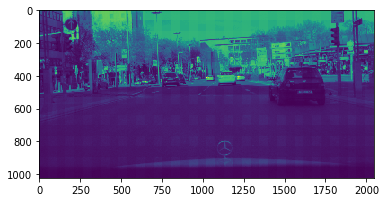

In [0]:
from PIL import Image
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import cv2

print(f"length of list: {len(LABEL_LIST)}")

test_path, test_bounding_boxes, test_states = get_label_and_path(LABEL_PATH, 300, LABEL_LIST)

print(f"path for the test: {test_path}")
        

# replace the unnecessary path with the other
test_path = test_path.replace("scratch/fs2/DTLD_final","content")
print(f"altered test_path: {test_path}")
print(f"does the path exist: {os.path.exists(test_path)}")

image = Image.open(test_path)
image_disp = Image.open("/content/Bochum/Bochum1/2015-04-21_17-09-21/DE_BBBR667_2015-04-21_17-09-21-420181_k0.tiff")

print("\n\nLet's look at the tensor")
image_tensor = ToTensor()(image)
print(f"shape of image tensor: {image_tensor.shape}")
print(f"image size: {image.size}")

# print out the stats for each light
print(f"\n\nnumber of traffic lights: {len(test_states)}")
print("\nstats on each light\n")
for i in range(len(test_states)):
  print(f"\nlight number: {i}")
  box = test_bounding_boxes[i]
  print(f"bounding box: x= {box[0]}, y= {box[1]}, wd= {box[2]}, ht= {box[3]}")
  color = LABELS[test_states[i]]
  print(f"color= {color}")

print("image")
imgplot = plt.imshow(image)





Now, we are ready to define our VisionDataset class using the code from above.

In [0]:
from torch.utils.data import Dataset
from torchvision import transforms 
from torchvision.datasets.vision import VisionDataset


makePIL = transforms.Compose(
      [  
      transforms.ToPILImage() 
      ])

class TLDataset(VisionDataset):
  def __init__(self, root_dir_images, label_dir):

    # will be used by the get_item method
    self.root_dir_images = root_dir_images
    self.label_dir = label_dir
    self.list_of_labels =  yaml.load(open(self.label_dir, 'rb').read())
    self.length = len(self.list_of_labels)
    
    # define the preprocessing for the images
    TLDataPreprocess = transforms.Compose(
      [  
      transforms.ToTensor() 
      ])
    self.transform = TLDataPreprocess
    return

  """
  needs to go through the yaml file and get the color.
  also, needs to go through and get the image of that id
  """
  def __getitem__(self, index):
    # function that gets the path, 
    img_path, b_boxes, states = get_label_and_path(self.label_dir, 
                                                   index, 
                                                   self.list_of_labels)

    # add the root directory to the file path if it does not work correctly
    full_image_file_path = img_path.replace("/scratch/fs2/DTLD_final",
                                            self.root_dir_images)

    # grab the image from the path found in the converted yaml file
    img = cv2.imread(full_image_file_path, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BAYER_GB2RGB)
    # Images are saved in 12 bit raw -> shift 4 bits
    img = np.right_shift(img, 4)
    img = img.astype(np.uint8)
    img_pil = Image.fromarray(img)
    image_data =  self.transform(img_pil).unsqueeze(0)
    # encapsulate the b_boxes and states into a np array
    output_arr = [b_boxes, states]
    output_arr = np.array(output_arr)

    return image_data, output_arr


  def __len__(self):
      """The number of photos in the dataset."""
      return len(self.list_of_labels)



Here, we will test our data loader to make sure it is consistent with the programming used above that to create the function



number of traffic lights: 3

stats on each light


light number: 0
bounding box: x1= 739, y1= 277, x2= 755, y2= 324
color= green

light number: 1
bounding box: x1= 1092, y1= 60, x2= 1123, y2= 139
color= green

light number: 2
bounding box: x1= 1302, y1= 246, x2= 1317, y2= 295
color= green
torch.Size([3, 1024, 2048])
<PIL.Image.Image image mode=RGB size=2048x1024 at 0x7F6B4A88EBE0>


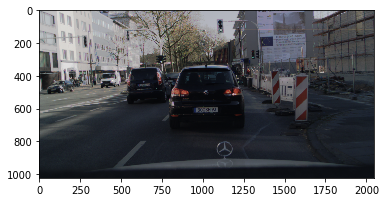

In [0]:
LABEL_PATH = "/content/Bochum_all.yml"
IMAGE_ROOT = "/content"
testNum = 200
# initialize the dataloader
train_data = TLDataset(IMAGE_ROOT, LABEL_PATH)

# extract the same sample taken above to make sure the behavior lines up
img, labels = train_data[testNum]
b_boxes, states = labels[0], labels[1]

# print out the stats to make sure they are consistent
print(f"\n\nnumber of traffic lights: {len(states)}")
print("\nstats on each light\n")
for i in range(len(b_boxes)):
  print(f"\nlight number: {i}")
  box = b_boxes[i]
  print(f"bounding box: x1= {box[0]}, y1= {box[1]}, x2= {box[2]}, y2= {box[3]}")
  color = LABELS[states[i]]
  print(f"color= {color}")

img_cpu = (img.cpu().squeeze(0))
print(img_cpu.shape)
img_pil = makePIL(img_cpu)
print(img_pil)
plt.imshow(img_pil)
plt.show()


#2 Traffic Light Object Detection

We use the "fasterrcnn_resnet50_fpn" pretrained on the COCO dataset in order to  detect the traffic lights. We will use this to build our intermediate dataset that will be trained upon for state (color) classification of the traffic lights. 

This function will help us later on to make sure that the labels for each bounding box prediction are correct.

In [0]:
import math

def get_matching_ground_truth_bbox(x_pred, y_pred, labels):
  # strip the bboxes form the labels array
  b_boxes, states = labels[0], labels[1]

  # for loop through the predicted boxes
  closest_distance = float("inf")
  closest_index = None
  for i in range(len(b_boxes)):
    curr_truth = b_boxes[i]
    x_truth = curr_truth[0]
    y_truth = curr_truth[1]

    curr_dist = (x_pred - x_truth)** 2 + (y_pred - y_truth) ** 2
    if curr_dist < closest_distance:
      closest_distance = curr_dist
      closest_index = i

  # output the closest bounding box
  
  return b_boxes[closest_index], states[closest_index] 



Run through a full example that gets the bounding boxes of the images with the pretrained network. After that, the predicted and ground truth bounding boxes are printed out.

device: cuda:0


Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 43.3MB/s]


torch.Size([1, 3, 1024, 2048])
shape of image: torch.Size([1, 3, 1024, 2048])
torch.Size([3, 1024, 2048])
<PIL.Image.Image image mode=RGB size=2048x1024 at 0x7F6B4A146B00>


'\nprint(f"number of gt lights: {len(labels[0])}")\nfor i in range(len(labels[0])):\n  gt_bbox = labels[0][i]\n  gt_x = gt_bbox[0]\n  gt_y = gt_bbox[1]\n  gt_w = gt_bbox[2] - gt_x\n  gt_h = gt_bbox[3] - gt_y\n  gt_rect = patches.Rectangle((gt_x, gt_y), gt_w, gt_h, linewidth=1, edgecolor=\'b\', facecolor=\'none\')\n  ax.add_patch(gt_rect)\n'

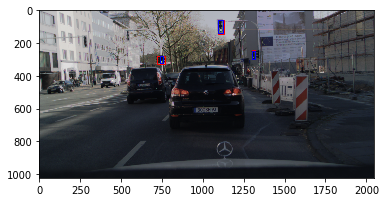

In [0]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torch
import matplotlib.patches as patches
import math

# setup the gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

# call the model as pretrained
detection_model = fasterrcnn_resnet50_fpn(pretrained=True)

# get one image that we can run through the network
img, labels = train_data[testNum]
print(img.shape)
# put the model in eval mode
detection_model = detection_model.to(device)
img = img.to(device)
#img = img.reshape(300,300,1,1)
detection_model.eval()

print(f"shape of image: {img.shape}")

# try the model on something
with torch.no_grad():
  predictions = detection_model(img)

#print(f"predictions of the bounding boxes: \n{(predictions[0]).get('boxes')}")
scoreThresh = 0.85
trafficLabel = 10
size = len((predictions[0]).get('boxes'))
iniboxes = []
s = []

for i in range (0,size):
  if((predictions[0]).get('labels')[i]==10 and (predictions[0]).get('scores')[i]>scoreThresh):
    iniboxes.append((predictions[0]).get('boxes')[i])
    s.append((predictions[0]).get('scores')[i])
    #print(i)
boxes = []
minDist = 50
for i in range(0,len(iniboxes)):
  add = True
  for j in range(0,len(iniboxes)):
    if(i!=j):
      d = math.sqrt((iniboxes[i][0]-iniboxes[j][0])**2 + (iniboxes[i][1]-iniboxes[j][1])**2)
      if(d<minDist and s[i]<s[j]):
        add = False
  if(add):
    boxes.append(iniboxes[i])
#print(len((predictions[0]).get('boxes')))
fig, ax = plt.subplots(1)
img_cpu = (img.cpu().squeeze(0))
print(img_cpu.shape)
img_pil = makePIL(img_cpu)
print(img_pil)
ax.imshow(img_pil)
#plt.show()
for i in range(0,len(boxes)):
  x = boxes[i][0]
  y = boxes[i][1]
  w = boxes[i][2]-x
  h = boxes[i][3]-y
  rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)

  ## Matching bounding box to ground truth bounding box For Training
  # this function gets the closest gt bounding box to the current rcnn bounding box
  gt_bbox, gt_state = get_matching_ground_truth_bbox(x,y, labels)
  gt_x = gt_bbox[0]
  gt_y = gt_bbox[1]
  gt_w = gt_bbox[2] - gt_x
  gt_h = gt_bbox[3] - gt_y
  gt_rect = patches.Rectangle((gt_x, gt_y), gt_w, gt_h, linewidth=1, edgecolor='b', facecolor='none')
  ax.add_patch(gt_rect)



"""
print(f"number of gt lights: {len(labels[0])}")
for i in range(len(labels[0])):
  gt_bbox = labels[0][i]
  gt_x = gt_bbox[0]
  gt_y = gt_bbox[1]
  gt_w = gt_bbox[2] - gt_x
  gt_h = gt_bbox[3] - gt_y
  gt_rect = patches.Rectangle((gt_x, gt_y), gt_w, gt_h, linewidth=1, edgecolor='b', facecolor='none')
  ax.add_patch(gt_rect)
"""


#3 Preprocessing the Data

Now, we need to build our dataset from the cropped out traffic lights. Since we are using a CNN, we do not need a set size for the input image.

In [0]:
from torch.utils.data import DataLoader
import os

# create the directories if they are not already found
if not(os.path.exists('/content/train/')):
  os.mkdir('/content/train/')

if not(os.path.exists('/content/val/')):
  os.mkdir('/content/val/')


# declare big array of dictionary
tl_dataset = train_data
#tl_dataloader = DataLoader(tl_dataset, batch_size= 1,
 #                          shuffle=False, num_workers=0)
#middle_dataset = []

# make sure that the model is set up and run on the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
detection_model = detection_model.to(device)
detection_model.eval()

# setup for file saving
traffic_i = 0
fname_to_label = dict()

# for all images in the training set
for i in range(len(tl_dataset)): 
	# get the converted image, bboxes and states from the datasets	
  img, labels = tl_dataset[i]
  img = img.to(device)
	
	# run through the rcnn, to get the bbox coordinates of all the traffic lights
  with torch.no_grad():
    predictions = detection_model(img)

  scoreThresh = 0.85
  trafficLabel = 10
  size = len((predictions[0]).get('boxes'))
  iniboxes = []
  s = []

  for j in range (0,size):
    if((predictions[0]).get('labels')[j]==10 and (predictions[0]).get('scores')[j]>scoreThresh):
      iniboxes.append((predictions[0]).get('boxes')[j])
      s.append((predictions[0]).get('scores')[j])
  
  # non max suppression of duplicate boxes
  boxes = []
  minDist = 50
  for j in range(0,len(iniboxes)):
    add = True
    for k in range(0,len(iniboxes)):
      if(j!=k):
        d = math.sqrt((iniboxes[j][0]-iniboxes[k][0])**2 + (iniboxes[j][1]-iniboxes[k][1])**2)
        if(d<minDist and s[j]<s[k]):
          add = False
    if(add):
      boxes.append(iniboxes[j])

  # for all of the bboxes that are above the threshold and classified as traffic lights
  for j in range(len(boxes)):
    # get the closest ground truth bounding box
    x = boxes[j][0]
    y = boxes[j][1]
    w = boxes[j][2]-x
    h = boxes[j][3]-y
    #print(f"x: {x}, y: {y}, w: {w}, h: {h}")

    ## Matching bounding box to ground truth bounding box For Training
    # this function gets the closest gt bounding box to the current rcnn bounding box
    gt_bbox, gt_state = get_matching_ground_truth_bbox(x,y, labels)

		# index the big image to get the tensor that includes the light
    #print(f"shape of total image: {img.shape}")
    squeezed_img = img.squeeze(0)
    #print(f"shape of squeezed image: {squeezed_img.shape}")
 
    traffic_light = squeezed_img[:,int(y):(int(y) + int(h)),int(x):(int(x) + int(w))]
    #print(f"shape of cropped image: {traffic_light.shape}")
    """
    im = makePIL(traffic_light.cpu())
    plt.imshow(im)
    plt.show()   
    print(f"label index: {gt_state}")
    print(f"state (color): {LABELS[gt_state]}")
    """

    # write to file
    img_pil = makePIL(traffic_light.cpu())
    
    file_path = str(traffic_i)
    if i < int(.75*(len(tl_dataset))):
      file_path = '/content/train/' + file_path
    else:
      file_path = '/content/val/' + file_path

    img_pil.save(file_path, "JPEG")
    # save the label so we can use it later
    fname_to_label[traffic_i] = gt_state
    
    traffic_i += 1

  img = img.cpu()

  

Now we can inspect the resulting dataset we made to make sure that it was partitioned correctly. Also, we need to make sure we can open the image. to make sure it did not change. We chose a 75% training dataset and 25% validation set.

size of training set: 776
size of validation set: 312
name of test file path: /content/train/668
color label: red


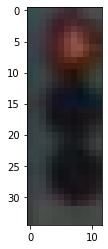

In [0]:
# check the size of the datasets
train_size = len(os.listdir("/content/train/"))
val_size = len(os.listdir("/content/val/"))

print(f"size of training set: {train_size}")
print(f"size of validation set: {val_size}")

TEST_I = 99

# open one of the images
test_img_file = "/content/train/" + os.listdir("/content/train/")[TEST_I] 
print(f"name of test file path: {test_img_file}")

# get the label
test_file_id = int(os.listdir("/content/train/")[TEST_I])
test_state = LABELS[fname_to_label[test_file_id]]
print(f"color label: {test_state}")
test_img_pil = Image.open(test_img_file)
plt.imshow(test_img_pil)
plt.show()


Here, we implement another VisionDataset class for the cropped traffic light images. This is the dataset that will be trained upon using ResNet. 

In [0]:

class TrafficLightData(Dataset):
  def __init__(self,training,transform):
    self.fname = ""
    if(training==True):
      self.fname = "/content/train/"
    else:
      self.fname = "/content/val/"
    
    self.transform = transform

  def __getitem__(self,idx):
    img_fname = self.fname + os.listdir(self.fname)[idx]
    file_id = int(os.listdir(self.fname)[idx])
    #print(file_id)
    state = fname_to_label[file_id]
    img = Image.open(img_fname)
    imgT = self.transform(img)

    return (imgT,state)
    
  def __len__(self):
    return (len(os.listdir(self.fname)))



Now, we will define our training loop function that will keep track of our testing and validation statistics.

In [0]:
def train_model(classifier, criterion, optimizer, 
                trainLoader, valLoader, n_epochs = 10):
  
  #classifier = classifier.cuda()
  
  # use a GPU
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_cuda else "cpu")

  epoch_arr = []
  training_accuracy = []
  validation_accuracy = []
  training_loss = []
  validation_loss = []
  r_correct = 0
  g_correct = 0
  y_correct = 0
  o_correct = 0

  r_total = 0
  g_total = 0
  y_total = 0
  o_total = 0

  
  
  weight = classifier.conv1.weight;
  bias = classifier.conv1.bias;

  classifier = classifier.to(device)
  # loop through by the number of epochs
  for epoch in range(0, n_epochs):

    epoch_arr.append(epoch)

    correct = 0
    cumloss = 0

    # go over all the training data one batch at a time
    for (i, (x,y)) in enumerate(trainLoader):
      x = x.to(device)
      y = y.to(device)
      
      # reshape
      yhat = classifier(x)

      loss = criterion(yhat, y)

      
      if weight.grad is not None:
        optimizer.zero_grad()

      # might not need this
      loss.backward()

      """
      weight.data.add(-learning_rate * weight.grad.data)
      bias.data.add(-learning_rate * bias.grad.data)
      """
      optimizer.step()


      with torch.no_grad():  # Stop recording operations for gradient computation.
        # Count the number of correct predictions on this batch.
        _, max_labels = yhat.max(1)   # Extract the max values from yhat.
        # Check if those match the correct values in y.
        # and store in cumulative variable of correct values so far during training.
        correct += (max_labels == y).sum().item() 
        # Also compute the cumulative loss so far during training.
        cumloss += loss.item()

    # report the accuracy    
    n = len(train_data)
    print('({0}) Training: loss = {1:.6f}, accuracy = {2:.6f}'
      .format(epoch, cumloss / n, correct / n))
    
    training_accuracy.append(correct/n)
    training_loss.append(cumloss/n)

    correct = 0
    cumloss = 0
    # Compute accuracy on the test set.
    with torch.no_grad(): # Do not record operations for grad computation.
      for (i, (x, y)) in enumerate(valLoader):
        #Move street light image to cuda
        x = x.to(device)
        y = y.to(device)

        # Compute predictions under the current model.
        yhat = classifier(x)

        # Check if those match the correct values in y.
        # and store in cumulative variable of correct values so far.
        _, max_labels = yhat.max(1)
        
        correct += (max_labels == y).sum().item()
        #red 0
        #y 1
        #g 2
        #o 3
        if(epoch==n_epochs-1):
          for a in range(0,y.shape[0]):
            if(y[a]==0):
              r_total+=1
              if(max_labels[a]==y[a]):
                r_correct+=1
            elif(y[a]==1):
              y_total+=1
              if(max_labels[a]==y[a]):
                y_correct+=1
            elif(y[a]==2):
              g_total+=1
              if(max_labels[a]==y[a]):
                g_correct+=1
            elif(y[a]==3):
              o_total+=1
              if(max_labels[a]==y[a]):
                o_correct+=1
        # Also compute the cumulative loss so far.
        cumloss += loss.item()
  
    n = len(validation_data)
    print('({0}) Validation: loss = {1:.6f}, accuracy = {2:.6f}'
      .format(epoch, cumloss / n, correct / n))
    print('\n')

    validation_loss.append(cumloss / n)
    validation_accuracy.append(correct / n)

  return epoch_arr, training_accuracy, validation_accuracy, training_loss, validation_loss, r_total, r_correct,y_total,y_correct, g_total, g_correct, o_total,o_correct

#4 Training the Model

In [0]:
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
batch_size = 128
preprocess = transforms.Compose(
    [transforms.Resize((100,100)),
     transforms.ToTensor()]
)
num_classes = 4
model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,num_classes)

learningRate = 0.05
optimizer = optim.SGD(model.parameters(),lr=learningRate)
criterion = nn.CrossEntropyLoss()

train_data = TrafficLightData(training=True,transform = preprocess)
validation_data = TrafficLightData(training=False,transform = preprocess)

tLoader = DataLoader(train_data,batch_size = batch_size, shuffle=True,num_workers=0)

vLoader = DataLoader(validation_data,batch_size = batch_size, shuffle=False,num_workers=0)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
model.to(device)
epoch_arr, training_accuracy, validation_accuracy, training_loss, validation_loss,r_total, r_correct,y_total,y_correct, g_total, g_correct, o_total,o_correct = train_model(model,criterion,optimizer,tLoader,vLoader,n_epochs = 10)

(0) Training: loss = 0.023536, accuracy = 0.579897
(0) Validation: loss = 0.008011, accuracy = 0.461538


(1) Training: loss = 0.007133, accuracy = 0.750000
(1) Validation: loss = 0.003008, accuracy = 0.830128


(2) Training: loss = 0.002925, accuracy = 0.875000
(2) Validation: loss = 0.000589, accuracy = 0.817308


(3) Training: loss = 0.002359, accuracy = 0.949742
(3) Validation: loss = 0.008548, accuracy = 0.185897


(4) Training: loss = 0.007473, accuracy = 0.796392
(4) Validation: loss = 0.007090, accuracy = 0.807692


(5) Training: loss = 0.008289, accuracy = 0.817010
(5) Validation: loss = 0.000985, accuracy = 0.669872


(6) Training: loss = 0.001573, accuracy = 0.938144
(6) Validation: loss = 0.001875, accuracy = 0.833333


(7) Training: loss = 0.001202, accuracy = 0.956186
(7) Validation: loss = 0.000353, accuracy = 0.730769


(8) Training: loss = 0.000725, accuracy = 0.987113
(8) Validation: loss = 0.002289, accuracy = 0.740385


(9) Training: loss = 0.001848, accuracy = 0.93

Red Correct: 27
Red Total:  37
Yellow Correct: 0
Yellow Total:  23
Green Correct: 193
Green Total:  252
Other Correct: 0
Other Total:  0


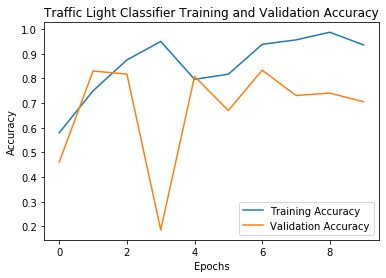

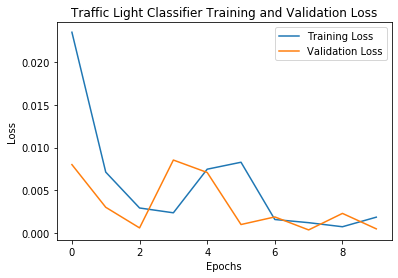

In [0]:
plt.figure()

plt.title('Traffic Light Classifier Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

tal, = plt.plot(epoch_arr,training_accuracy,label='Training Accuracy')
val, = plt.plot(epoch_arr,validation_accuracy,label='Validation Accuracy')
plt.legend(handles=[tal, val])


plt.figure()
plt.title('Traffic Light Classifier Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
tll, = plt.plot(epoch_arr,training_loss,label='Training Loss')
vll, = plt.plot(epoch_arr,validation_loss, label = "Validation Loss")
plt.legend(handles=[tll,vll])

print(f"Red Correct: {r_correct}")
print(f"Red Total:  {r_total}")

print(f"Yellow Correct: {y_correct}")
print(f"Yellow Total:  {y_total}")

print(f"Green Correct: {g_correct}")
print(f"Green Total:  {g_total}")

print(f"Other Correct: {o_correct}")
print(f"Other Total:  {o_total}")

#5 Good/Bad Examples of Model 

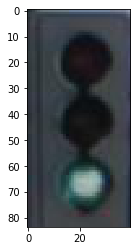

color label: green
Prediction: green


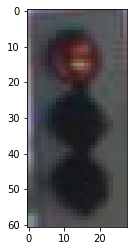

color label: red
Prediction: red


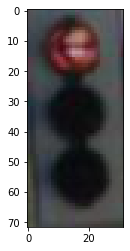

color label: yellow
Prediction: red


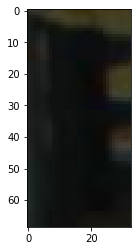

color label: yellow
Prediction: red


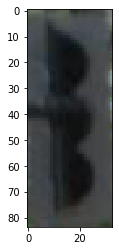

color label: red
Prediction: green


In [0]:
# check the size of the datasets


TEST_I_List = [100,132,69,298,149]

# open one of the images
"""
for TEST_I in range(0,312):
  test_img_file = "/content/val/" + os.listdir("/content/val/")[TEST_I] 
  # get the label
  test_file_id = int(os.listdir("/content/val/")[TEST_I])
  test_state = LABELS[fname_to_label[test_file_id]]
  if(fname_to_label[test_file_id]==1):
    print(TEST_I)
"""
for TEST_I in TEST_I_List:
  test_img_file = "/content/val/" + os.listdir("/content/val/")[TEST_I] 
  #print(f"name of test file path: {test_img_file}")
  # get the label
  test_file_id = int(os.listdir("/content/val/")[TEST_I])
  test_state = LABELS[fname_to_label[test_file_id]]
  #print(f"color label: {test_state}")
  test_img_pil = Image.open(test_img_file)
  plt.imshow(test_img_pil)
  plt.show()
  model.eval()
  t = preprocess(test_img_pil).unsqueeze(0)
  t = t.to(device)
  yhat = model(t)
  #print(yhat)
  _,b = yhat.max(1)
  print(f"color label: {test_state}")
  print(f"Prediction: {LABELS[b]}")
  